### Predict a new dataset

This notebook goes through the steps to use a trained model to classify new images.

Import the necessary packages and modules:

In [1]:
import glob

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import metrics
import seaborn as sns

Check that the installed version of Tensorflow is <= 1.15.5.

In [2]:
tf.__version__

'1.15.5'

### Normalization
The images during the training were normalized to have zero mean and a standard deviation of one. All the images to be classified need to be normalized in the same manner.

In [3]:
def normalize(x):
    xm = x.mean(axis=(1,2), keepdims=True)
    sm = x.std(axis=(1,2), keepdims=True)
    xn  = (x - xm)/sm
    return xn

### Load images

Load images from numpy files. To convert from tiff files into a numpy file, see the
[Image preprocessing](image_preprocessing.ipnby) notebook.

A list of numpy files in a folder is created, and one of them is opened to display an image. The list of files will be used for classification below.

In [ ]:
npfiles = sorted(glob.glob('Data/Male/npfiles/*.npy'))

data = np.load(npfiles[2])
data = normalize(data)

### Display images

Example images can be displayed to make sure they are loaded properly.

(4773, 64, 64, 3)


(array([-24.728376 ,  -1.6595844,  -1.6212324], dtype=float32),
 array([31.560041, 43.219425, 22.417572], dtype=float32),
 array([-8.6545418e-07, -2.0546072e-07, -2.0219151e-08], dtype=float32))

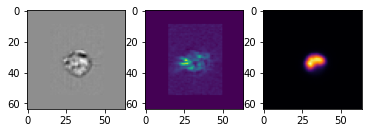

In [6]:
plt.figure(figsize=(6,2))
plt.subplot(1,3,1)
plt.imshow(data[2567,:,:,0], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(data[2567,:,:,1])
plt.subplot(1,3,3)
plt.imshow(data[2567,:,:,2], cmap='inferno')

print(data.shape)
data.min(axis=(0,1,2)), data.max(axis=(0,1,2)), data.mean(axis=(0,1,2))

### Load the Tensorflow checkpoint

The Tensorflow checkpoint saved during the training is loaded into the Tensorflow session. The input into the network is the `images` variable, and the output probabilities from the network are the variable `softmax`.

In [7]:

checkpoint = 'Checkpoints/test/cp-2021-05-04-16-07/checkpoint-24999'
tf.reset_default_graph()
sess = tf.Session()

cpmeta = checkpoint + '.meta'
saver = tf.train.import_meta_graph(cpmeta)
saver.restore(sess, checkpoint)

softmax = sess.graph.get_tensor_by_name('Softmax:0')
images = sess.graph.get_tensor_by_name('Placeholder:0')

INFO:tensorflow:Restoring parameters from Checkpoints/test/cp-2021-05-04-16-07/checkpoint-24999


### Image and softmax info

Print the objects `images` and `softmax` to see sizes and types.

In [9]:
images, softmax

(<tf.Tensor 'Placeholder:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'Softmax:0' shape=(?, 7) dtype=float32>)

### Classify images

Iterate over all numpy files and run the classifier on the images in each one. The output of the cell below will be a pandas dataframe with the prediction for all images.

In [11]:
df_list = list()

for f in npfiles:
    s = slice(16, 48)
    _data = normalize(np.load(f))[:, s, s, :]
    #_data = (np.load(f))[:, s, s, :]
    print(f, _data.shape)
    _probs = sess.run(softmax, feed_dict={images:_data})
    _c = _probs.argmax(axis=-1)
    _df = pd.DataFrame({'probability':_probs.max(axis=-1),
                       'class':_c, 'dataset':f})
    df_list.append(_df)

xdf = pd.concat(df_list, axis=0)

Data/Male/npfiles/Tifs_Snail_Male_R1.npy (6832, 32, 32, 3)
Data/Male/npfiles/Tifs_Snail_Male_R2.npy (7225, 32, 32, 3)
Data/Male/npfiles/Tifs_Snail_Male_R3.npy (4773, 32, 32, 3)
Data/Male/npfiles/Tifs_Snail_Male_R4.npy (5917, 32, 32, 3)
Data/Male/npfiles/Tifs_Snail_Male_R5.npy (7755, 32, 32, 3)


In [12]:
xdf.head()

,probability,class,dataset
0,0.720365,4,Data/Male/npfiles/Tifs_Snail_Male_R1.npy
1,0.969186,6,Data/Male/npfiles/Tifs_Snail_Male_R1.npy
2,0.994857,0,Data/Male/npfiles/Tifs_Snail_Male_R1.npy
3,0.725893,6,Data/Male/npfiles/Tifs_Snail_Male_R1.npy
4,0.636035,4,Data/Male/npfiles/Tifs_Snail_Male_R1.npy


### Make a bar plot

Using the pandas dataframe created above, a plot of the counts in each class can be made.

<AxesSubplot:xlabel='class', ylabel='probability'>

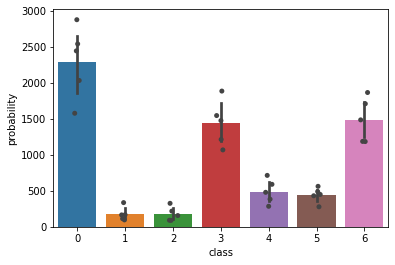

In [16]:
pv = xdf.groupby(['dataset','class']).agg('count').reset_index()
sns.barplot(data=pv, x='class', y='probability')
sns.stripplot(data=pv, x='class', y='probability', color='#444444')